## Introduction

The notebook calculates the partial differential equation of 1st order. For this case, Burgers Equation is being utilized. 

The implementation is done in PyTorch as it provides ease in creating the graph of the network. Furthermore, the implementation is based on the paper "Fourier Neural Operator for Parametric Partial Differential Equation" [link] and the code is mostly taken from the repository that the authors have released. The github link to the orginal repository is . Whereas, the link to our work is .

## Libraries 

The following cell import all the necessary libraries required to carry out the task. The utilities are added into the python script of utilities.py and it is being called in the following cell. 

In [1]:
import importlib
import utilities
importlib.reload(utilities)
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer

## Prelimaries 

The following cell set some prelimaries that will be used throughout the notebook. The description of the variables are mentioned infront of them for the ease of the user. 

In [1]:
ntrain = 1000 # Number of training examples
ntest = 100 # Number of testing examples

sub = 1 #subsampling rate
h = 2**13 // sub
s = h 

batch_size = 20
learning_rate = 0.001

epochs = 10
step_size = 100 # steps set for LR scheduler
gamma = 0.5 # parameter set for LR scheduler

modes = 12 # modes for fourier transform
width = 32 # number of nodes/filters

## Data Retrival 

The data is saved in a MATLAB file and that is being retrived using the MatReader function developed in the utilities script.

In [3]:
dataloader = utilities.MatReader('data/burgers_data_R10.mat')
x_data = dataloader.read_field('a')[:,::sub]
y_data = dataloader.read_field('u')[:,::sub]

In [4]:
print(f'The shape of x is {x_data.shape} and the shape of y is {y_data.shape}')

The shape of x is torch.Size([2048, 8192]) and the shape of y is torch.Size([2048, 8192])


Once the data is being retrived the data is being split into the training and testing sets. The parameter for training and testing size is being declared in the prelimaries section

In [5]:
x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

In [6]:
print(f'The shape of x_train is {x_train.shape} and the shape of y_train is {y_train.shape}')
print(f'The shape of x_test is {x_test.shape} and the shape of y_test is {y_test.shape}')

The shape of x_train is torch.Size([1000, 8192]) and the shape of y_train is torch.Size([1000, 8192])
The shape of x_test is torch.Size([100, 8192]) and the shape of y_test is torch.Size([100, 8192])


The x_train and x_test is being combined with the grid of the of values of the indices

In [ ]:
grid=np.linspace(0, 2*np.pi, s).reshape(1, s, 1)
grid = torch.tensor(grid,dtype=torch.float)

x_train=torch.cat([x_train.reshape(ntrain,s,1), grid.repeat(ntrain,1,1)], dim=2)
x_test = torch.cat([x_test.reshape(ntest,s,1), grid.repeat(ntest,1,1)], dim=2)

print(f'The shape of x_train is {x_train.shape} and the shape of y_train is {y_train.shape}')
print(f'The shape of x_test is {x_test.shape} and the shape of y_test is {y_test.shape}')

# Model

The following cell declares the model that is being used. The model is developed using 3 classes. The main class is Net1d which calls the second class which is SimpleBlock1d and that calls SpectralConv1d class.

The following image is the illustration of the model that is being created. 

The upper region (Section 1) is implemented in SpectralConv1d. The class first performs fourier transform on the the signal and then after taking the specified modes, returns to the original form. 

The lower region (Section 2) is not implemented separately as it is just a weight matrix. However, the combination of the output after the fourier neural operation and weight matrix is done in the class of the SimpleBlock1d. 

The class Net1d just combines everything together. 

In [8]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, 2))

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.rfft(x, 1, normalized=True, onesided=True)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.in_channels, x.size(-1)//2 + 1, 2, device=x.device)
        out_ft[:, :, :self.modes1] = compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.irfft(out_ft, 1, normalized=True, onesided=True, signal_sizes=(x.size(-1), ))
        return x

class SimpleBlock1d(nn.Module):
    def __init__(self, modes, width):
        super(SimpleBlock1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
#         self.conv4 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
#         self.w4 = nn.Conv1d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm1d(self.width)
        self.bn1 = torch.nn.BatchNorm1d(self.width)
        self.bn2 = torch.nn.BatchNorm1d(self.width)
        self.bn3 = torch.nn.BatchNorm1d(self.width)
#         self.bn4 = torch.nn.BatchNorm1d(self.width)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = self.bn0(x1 + x2)
        x = F.relu(x)
        
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = self.bn1(x1 + x2)
        x = F.relu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = self.bn2(x1 + x2)
        x = F.relu(x)
        
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = self.bn3(x1 + x2)
#         x = F.relu(x)
        
#         x1 = self.conv4(x)
#         x2 = self.w4(x)
#         x = self.bn4(x1 + x2)
#         x = F.relu(x)
        

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Net1d(nn.Module):
    def __init__(self, modes, width):
        super(Net1d, self).__init__()

        """
        A wrapper function
        """

        self.conv1 = SimpleBlock1d(modes, width)
        self.dense1 = nn.Linear(8192,8192)


    def forward(self, x):
        x = self.conv1(x)
#         x = x.squeeze()
        return x.squeeze()

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c
    
def compl_mul1d(a, b):
    # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
    op = partial(torch.einsum, "bix,iox->box")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)

The following cell creates the object train_loader and test_loader that can be used for the training and testing purposes.

In [9]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [10]:
model = Net1d(modes, width).cuda()

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

### Training of the Model

The training of the model is straightforward. The only thing to notice that for the loss function, Lp Loss is being used. However, MSE can also be used as it results in the similar outlook. The implementation of the Lp Loss can be found in the utilities script.

In [12]:
myloss = utilities.LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
#         print(out.shape)
        mse = F.mse_loss(out, y, reduction='mean')
        # mse.backward()
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

C:\Users\Saad.LAKES\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
C:\Users\Saad.LAKES\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:602.)


0 3.286784599999997 0.025036237705498933 0.33676570177078247 0.18355728149414063
1 1.799664700000001 0.009277029298245906 0.19901005935668944 0.12222155809402466
2 1.8658199999999994 0.007231059849727899 0.17692686605453492 0.11760056257247925
3 1.860438099999996 0.005431048516184092 0.14777561378479004 0.09801856398582459
4 1.792230999999994 0.006300721664447337 0.15911061358451845 0.09128805160522462
5 1.7371787999999952 0.007105820111464709 0.16158499658107758 0.0660643494129181
6 1.7435553999999982 0.0035618344694375993 0.11152885270118713 0.09353924632072448
7 1.7437170000000037 0.0039217794762225824 0.11666908067464829 0.07848817348480225
8 1.7489525000000015 0.005196466578636319 0.13838024616241454 0.07265140056610107
9 1.738608400000004 0.0034170761913992465 0.11238515889644622 0.09314745664596558


### Prediction Phase

The following cell does the testing on the testing data. 

In [13]:
pred = torch.zeros(y_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
#         print(index, test_l2)
        index = index + 1

In [14]:
print(f'The shape of predictions is {pred.shape} and the shape of ground truth is {y_test.shape}')

The shape of predictions is torch.Size([100, 8192]) and the shape of ground truth is torch.Size([100, 8192])


## Visualization

Once the prediction is being performed it is being plotted against the actual values to visualize the results. The following cell does that and after that MSE is also calculated which is found to be close to zero which shows that the model is able to predict the actual values with great precision.

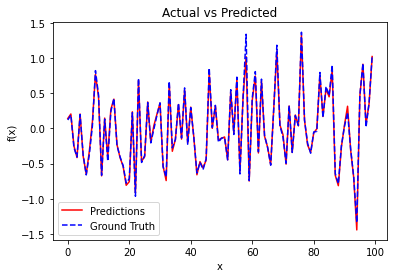

In [25]:
plt.plot(pred[:,8191],'r-',label='Predictions')
plt.plot(y_test[:,8191],'b--',label='Ground Truth')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Actual vs Predicted')
plt.legend(loc='lower left')
plt.savefig('Output_burgers')
plt.show()

In [16]:
F.mse_loss(pred,y_test)

tensor(0.0020)